In [7]:
%pip install camel-tools -qq
%pip install arabic-reshaper -qq
%pip install python-bidi -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 19.2 MB/s eta 0:00:00


In [9]:
import networkx as nx
import matplotlib.pyplot as plt
from camel_tools.disambig.mle import MLEDisambiguator
from camel_tools.tagger.default import DefaultTagger
from camel_tools.tokenizers.word import simple_word_tokenize
import arabic_reshaper
from bidi.algorithm import get_display
import re
from IPython.display import display, HTML

In [15]:
# Preprocessing function
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text.strip())
    text = re.sub(r'[^\u0600-\u06FF\s.,!?]', '', text)
    if not text:
        return None
    return text

In [16]:
# Function to split text into sentences
def split_into_sentences(text):
    # Improved regex for Arabic sentence splitting
    sentences = re.split(r'[.،!؟]+(?=\s|$)', text)
    return [s.strip() for s in sentences if s.strip()]

In [33]:
import subprocess
import sys
import os

try:
    print("Attempting to load CALIMA-MSA-R13...")
    disambiguator = MLEDisambiguator.pretrained('calima-msa-r13')
    tagger = DefaultTagger(disambiguator, feature='pos')
    print("Models initialized successfully!")
except Exception as e:
    print(f"CALIMA model not available: {e}")

Attempting to load CALIMA-MSA-R13...
Models initialized successfully!


In [26]:
def create_pos_graph(tokens, tags, sentence_idx=0):
    """Create a directed graph for POS tagging visualization"""
    G = nx.DiGraph()
    pos = {}
    spacing = 8
    max_tokens_per_row = 5
    base_y = -sentence_idx * 10

    for j, (word, tag) in enumerate(zip(tokens, tags)):
        reshaped_word = get_display(arabic_reshaper.reshape(word))
        unique_word = f"{reshaped_word}_{sentence_idx}_{j}"
        tag_node = f"{tag}_{sentence_idx}_{j}"

        G.add_node(unique_word, type='word')
        G.add_node(tag_node, type='tag', label=tag)
        G.add_edge(unique_word, tag_node)

        if j > 0:
            G.add_edge(f"{tags[j-1]}_{sentence_idx}_{j-1}", tag_node)

        row = j // max_tokens_per_row
        col = j % max_tokens_per_row
        x_pos = (max_tokens_per_row - 1 - col) * spacing
        y_word = base_y - row * 2

        pos[unique_word] = (x_pos, y_word + 1)
        pos[tag_node] = (x_pos, y_word)

    return G, pos


In [27]:
def analyze_and_visualize(text):
    """Main function to analyze Arabic text and create visualizations"""
    # Preprocess text
    processed_text = preprocess_text(text)
    if not processed_text:
        print("❌ Please enter valid Arabic text")
        return

    # Split into sentences
    sentences = split_into_sentences(processed_text)
    if not sentences:
        print("❌ No valid sentences found")
        return

    print(f"📝 Processing {len(sentences)} sentence(s)...")
    print("=" * 50)

    # Create visualization
    total_tokens = sum(len(simple_word_tokenize(sent)) for sent in sentences)
    fig_width = max(12, len(sentences) * 6)
    fig_height = max(8, (total_tokens + 5 - 1) // 5 * 3)

    fig, axes = plt.subplots(len(sentences), 1, figsize=(fig_width, fig_height))
    if len(sentences) == 1:
        axes = [axes]

    fig.suptitle('Arabic POS Tagging Analysis', fontsize=16, fontweight='bold')

    for i, sent in enumerate(sentences):
        tokens = simple_word_tokenize(sent)
        if not tokens:
            continue

        try:
            tags = tagger.tag(tokens)

            # Print analysis results
            print(f"Sentence {i+1}: {sent}")
            print("Token Analysis:")
            for j, (word, tag) in enumerate(zip(tokens, tags)):
                reshaped_word = get_display(arabic_reshaper.reshape(word))
                print(f"  {j+1}. {reshaped_word} → {tag}")
            print("-" * 30)

            # Create graph
            G, pos = create_pos_graph(tokens, tags, i)

            # Plot graph
            ax = axes[i]
            ax.set_title(f"Sentence {i+1} - POS Structure", pad=20, fontsize=14)
            ax.axis('off')

            # Color nodes by type
            node_colors = ['lightblue' if G.nodes[node]['type'] == 'word'
                          else 'lightgreen' for node in G.nodes]

            # Draw network
            nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                                 node_size=800, ax=ax)
            nx.draw_networkx_edges(G, pos, arrowstyle='->',
                                 arrowsize=20, ax=ax, edge_color='gray')

            # Add labels
            for node, (x, y) in pos.items():
                if G.nodes[node]['type'] == 'tag':
                    label = G.nodes[node]['label']
                    ax.text(x, y, label, ha='center', va='center',
                           rotation=45, fontweight='bold', fontsize=10,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
                else:
                    label = node.split('_')[0]
                    ax.text(x, y, label, ha='center', va='center',
                           fontweight='bold', fontsize=12,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

        except Exception as e:
            print(f"❌ Error processing sentence {i+1}: {e}")
            continue

    plt.tight_layout()
    plt.show()

    # Summary statistics
    all_tokens = []
    all_tags = []
    for sent in sentences:
        tokens = simple_word_tokenize(sent)
        if tokens:
            tags = tagger.tag(tokens)
            all_tokens.extend(tokens)
            all_tags.extend(tags)

    print("\n📊 Analysis Summary:")
    print(f"Total sentences: {len(sentences)}")
    print(f"Total tokens: {len(all_tokens)}")
    print(f"Unique POS tags: {len(set(all_tags))}")
    print(f"POS tags found: {', '.join(sorted(set(all_tags)))}")


🔧 Arabic POS Tagging System Ready!
📋 Use the analyze_arabic_text() function to analyze Arabic text

Example usage:
analyze_arabic_text('هذا كتاب جميل جداً')
analyze_arabic_text('أحب القراءة في المكتبة')

🌟 Demo 1: Simple sentence analysis
📝 Processing 1 sentence(s)...
Sentence 1: هذا كتاب جميل
Token Analysis:
  1. ﺍﺬﻫ → pron_dem
  2. ﺏﺎﺘﻛ → noun
  3. ﻞﻴﻤﺟ → noun_prop
------------------------------


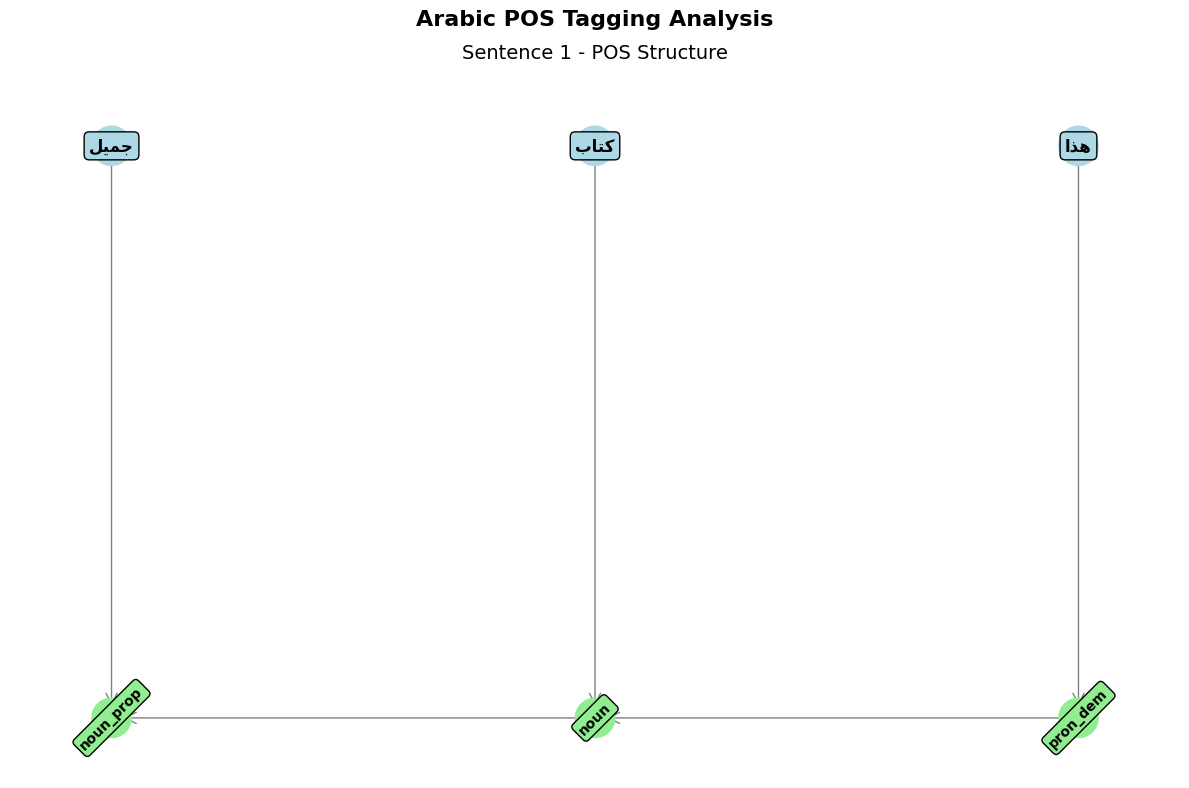


📊 Analysis Summary:
Total sentences: 1
Total tokens: 3
Unique POS tags: 3
POS tags found: noun, noun_prop, pron_dem

🌟 Demo 2: Complex sentence analysis
📝 Processing 1 sentence(s)...
Sentence 1: يذهب الطلاب إلى المدرسة كل يوم صباحاً
Token Analysis:
  1. ﺐﻫﺬﻳ → verb
  2. ﺏﻼﻄﻟﺍ → noun
  3. ﻰﻟﺇ → prep
  4. ﺔﺳﺭﺪﻤﻟﺍ → noun
  5. ﻞﻛ → noun
  6. ﻡﻮﻳ → noun
  7. ﺎﺣﺎﺒﺻ → noun
------------------------------


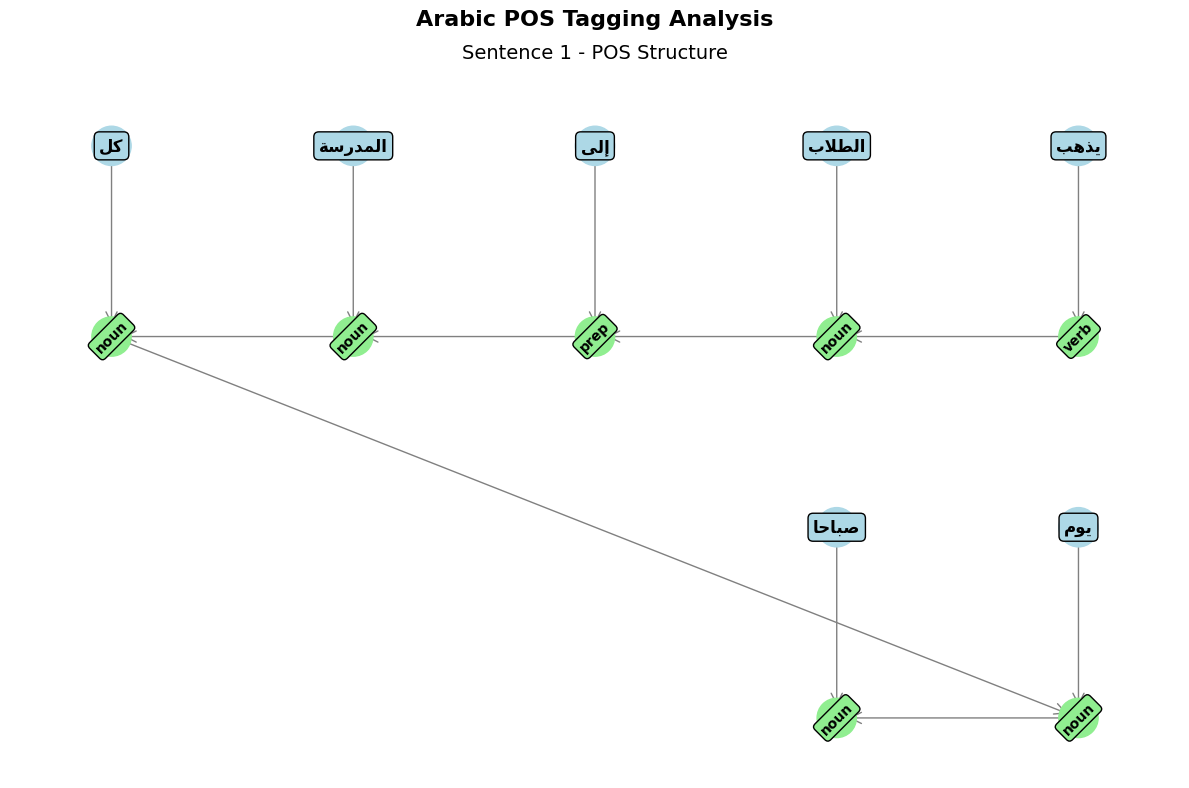


📊 Analysis Summary:
Total sentences: 1
Total tokens: 7
Unique POS tags: 3
POS tags found: noun, prep, verb

🌟 Demo 3: Multiple sentences analysis
📝 Processing 3 sentence(s)...
Sentence 1: أحب القراءة
Token Analysis:
  1. ﺐﺣﺃ → verb
  2. ﺓﺀﺍﺮﻘﻟﺍ → noun
------------------------------
Sentence 2: الكتب مفيدة جداً
Token Analysis:
  1. ﺐﺘﻜﻟﺍ → noun
  2. ﺓﺪﻴﻔﻣ → adj
  3. ﺍﺪﺟ → noun
------------------------------
Sentence 3: المكتبة مكان هادئ
Token Analysis:
  1. ﺔﺒﺘﻜﻤﻟﺍ → noun
  2. ﻥﺎﻜﻣ → noun
  3. ﺉﺩﺎﻫ → adj
------------------------------


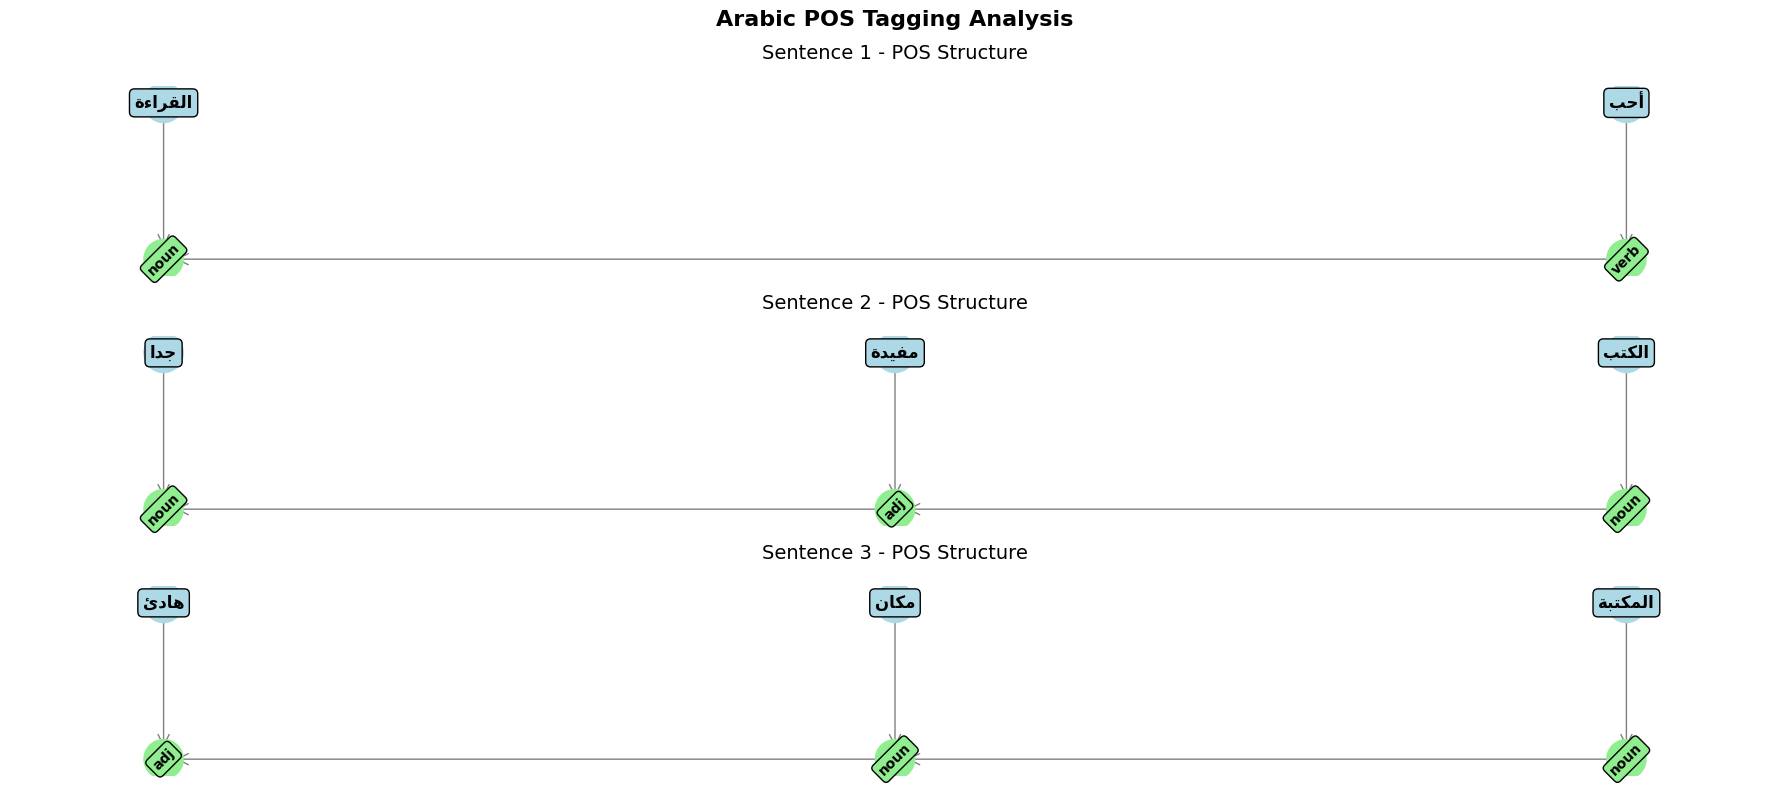


📊 Analysis Summary:
Total sentences: 3
Total tokens: 8
Unique POS tags: 3
POS tags found: adj, noun, verb

📝 INTERACTIVE ANALYSIS
Enter your Arabic text below and run the cell to analyze:


In [34]:
def analyze_arabic_text(text):
    """
    Analyze Arabic text for Part-of-Speech tagging with visualization

    Parameters:
    text (str): Arabic text to analyze
    """
    if not text or not text.strip():
        print("⚠️ Please provide some Arabic text to analyze")
        return

    analyze_and_visualize(text)

# Cell 6: Example Usage
print("🔧 Arabic POS Tagging System Ready!")
print("📋 Use the analyze_arabic_text() function to analyze Arabic text")
print("\nExample usage:")
print("analyze_arabic_text('هذا كتاب جميل جداً')")
print("analyze_arabic_text('أحب القراءة في المكتبة')")

# Cell 7: Demo Analysis
# Uncomment and run the following examples:

# Example 1: Simple sentence
print("\n🌟 Demo 1: Simple sentence analysis")
analyze_arabic_text("هذا كتاب جميل")

# Example 2: Complex sentence
print("\n🌟 Demo 2: Complex sentence analysis")
analyze_arabic_text("يذهب الطلاب إلى المدرسة كل يوم صباحاً")

# Example 3: Multiple sentences
print("\n🌟 Demo 3: Multiple sentences analysis")
analyze_arabic_text("أحب القراءة. الكتب مفيدة جداً. المكتبة مكان هادئ")

# Cell 8: Interactive Input Cell
print("\n" + "="*60)
print("📝 INTERACTIVE ANALYSIS")
print("="*60)
print("Enter your Arabic text below and run the cell to analyze:")


أدخل النص العربي هنا: اللَّهُ لَا إِلَهَ إِلَّا هُوَ الْحَيُّ الْقَيُّومُ لَا تَأْخُذُهُ سِنَةٌ وَلَا نَوْمٌ لَهُ مَا فِي السَّمَاوَاتِ وَمَا فِي الْأَرْضِ مَنْ ذَا الَّذِي يَشْفَعُ عِنْدَهُ إِلَّا بِإِذْنِهِ يَعْلَمُ مَا بَيْنَ أَيْدِيهِمْ وَمَا خَلْفَهُمْ وَلَا يُحِيطُونَ بِشَيْءٍ مِنْ عِلْمِهِ إِلَّا بِمَا شَاءَ وَسِعَ كُرْسِيُّهُ السَّمَاوَاتِ وَالْأَرْضَ وَلاَ يَؤُودُهُ حِفْظُهُمَا وَهُوَ الْعَلِيُّ الْعَظِيمُ
📝 Processing 1 sentence(s)...
Sentence 1: اللَّهُ لَا إِلَهَ إِلَّا هُوَ الْحَيُّ الْقَيُّومُ لَا تَأْخُذُهُ سِنَةٌ وَلَا نَوْمٌ لَهُ مَا فِي السَّمَاوَاتِ وَمَا فِي الْأَرْضِ مَنْ ذَا الَّذِي يَشْفَعُ عِنْدَهُ إِلَّا بِإِذْنِهِ يَعْلَمُ مَا بَيْنَ أَيْدِيهِمْ وَمَا خَلْفَهُمْ وَلَا يُحِيطُونَ بِشَيْءٍ مِنْ عِلْمِهِ إِلَّا بِمَا شَاءَ وَسِعَ كُرْسِيُّهُ السَّمَاوَاتِ وَالْأَرْضَ وَلاَ يَؤُودُهُ حِفْظُهُمَا وَهُوَ الْعَلِيُّ الْعَظِيمُ
Token Analysis:
  1. ﷲ → noun_prop
  2. ﻻ → part_neg
  3. ﻪﻟﺇ → noun
  4. ﻻﺇ → part
  5. ﻮﻫ → pron
  6. ﻲﺤﻟﺍ → noun
  7. ﻡﻮﻴﻘﻟﺍ → noun_prop
  

/tmp/ipython-input-1529907781.py:80: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


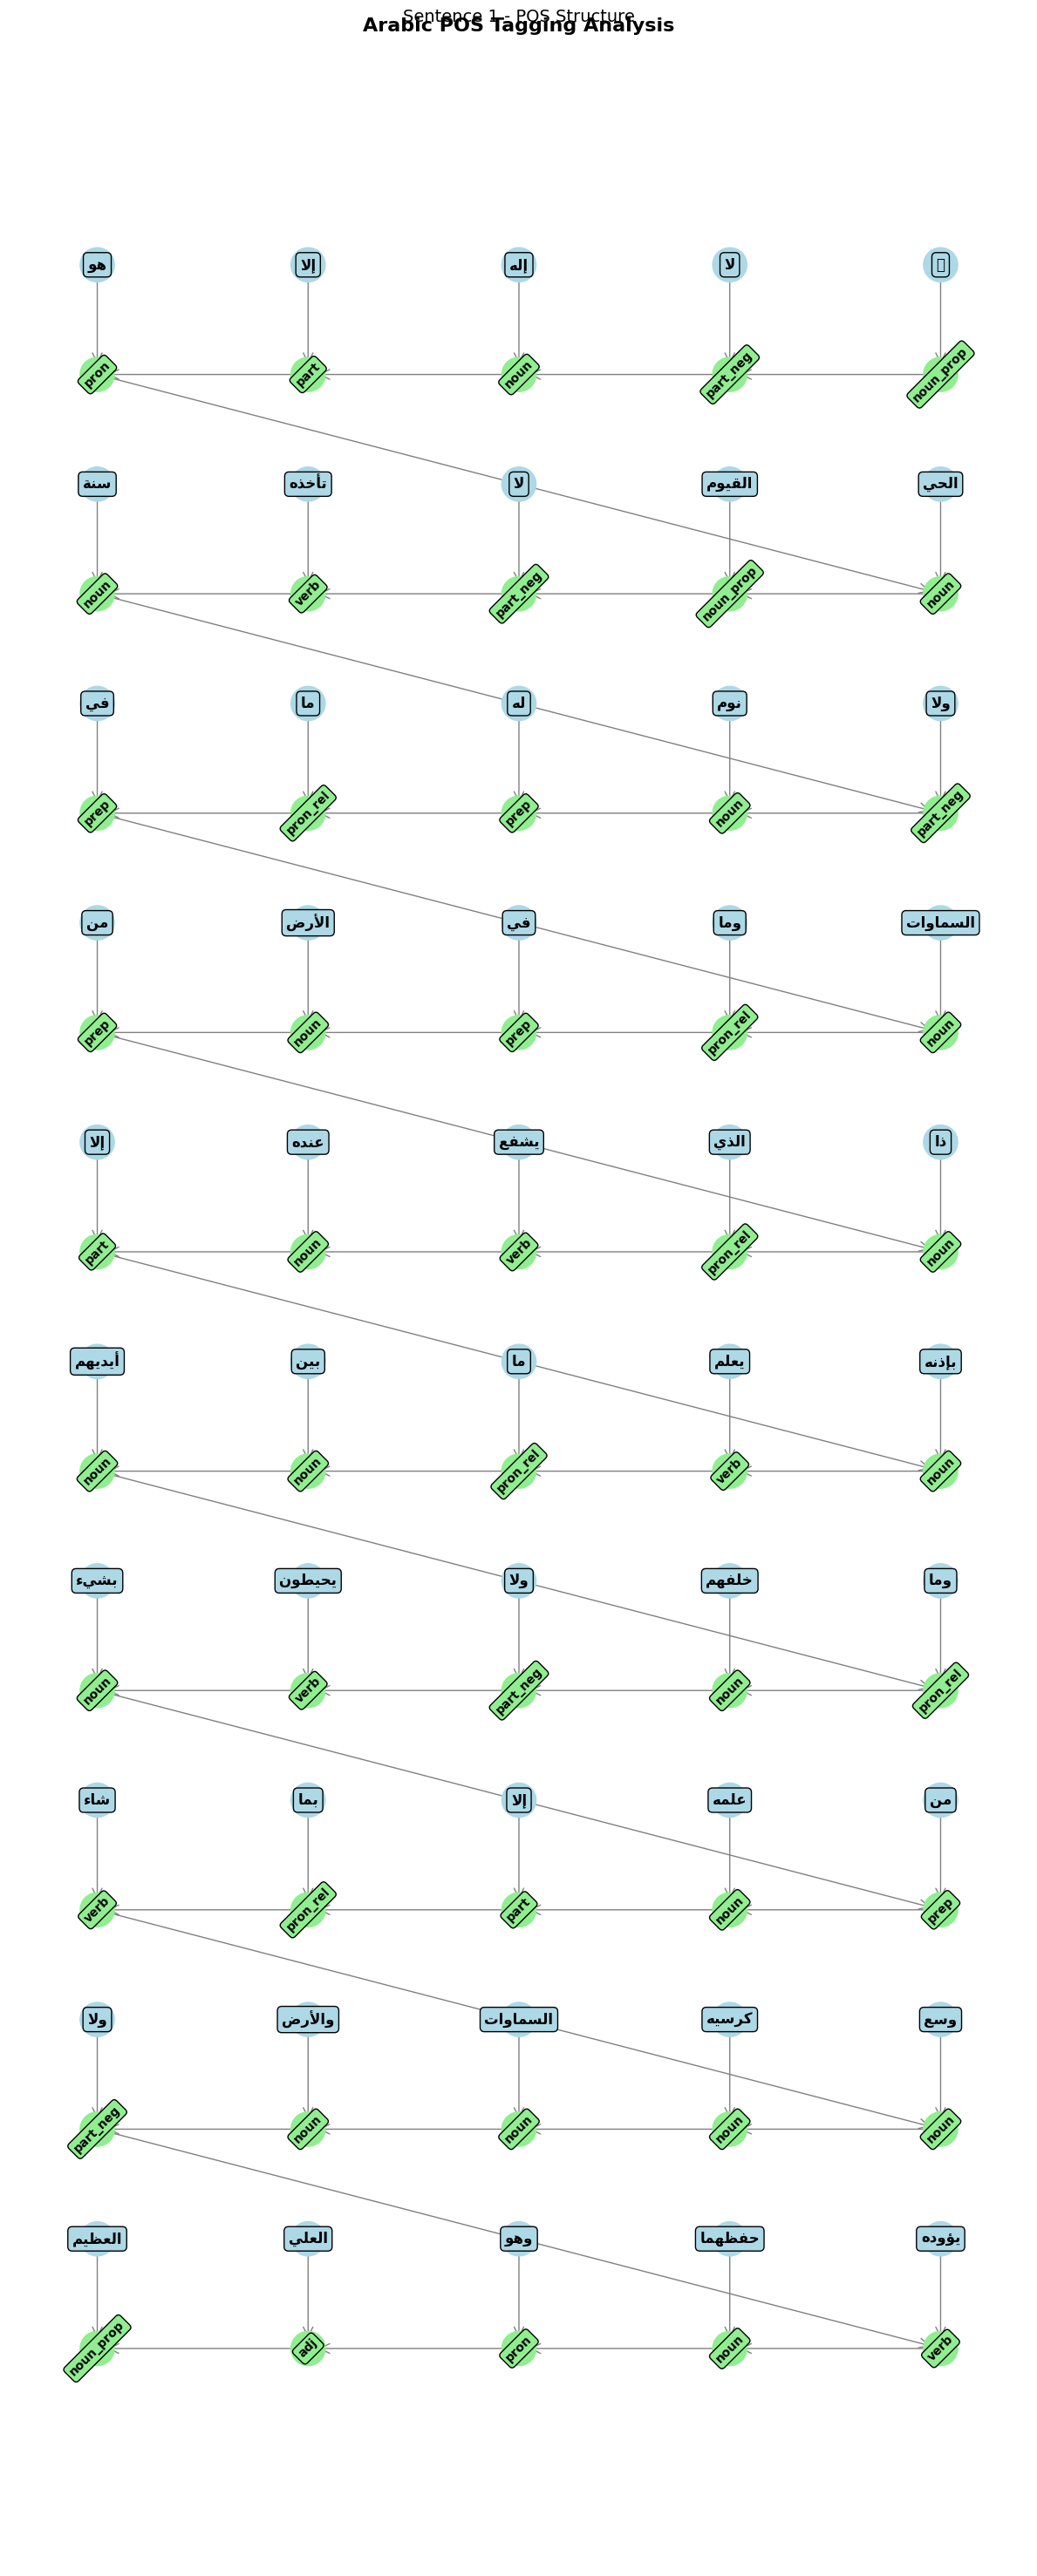


📊 Analysis Summary:
Total sentences: 1
Total tokens: 50
Unique POS tags: 9
POS tags found: adj, noun, noun_prop, part, part_neg, prep, pron, pron_rel, verb


In [35]:
user_text = input("أدخل النص العربي هنا: ")
analyze_arabic_text(user_text)